### Final, Tuned MLP Model

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

df = pd.read_csv("pricedata.csv")
numeric_features = ["Stories", "Year_Built", "Rooms", "FinishedSqft", "Units",
                    "Bdrms", "Fbath", "Hbath", "FIREPLACE", "AIR_CONDITIONING", "POWDER_ROOMS"]
categorical_features = ["PropType", "Style", "Extwall"]

all_numeric= numeric_features + ['Sale_price']
for col in all_numeric: #convert all numeric values to a string (helps to remove commas and dollar signs)
    df[col] = df[col].astype(str)

for col in all_numeric: #remove commas from numeric values
    df[col] = df[col].str.replace(',', '', regex=False)

for col in all_numeric: #remove dollar signs from numeric values
    df[col] = df[col].str.replace(r'\$', '', regex=True)

for col in all_numeric: #convert back to numeric (coerce is just to handle nan)
    df[col] = pd.to_numeric(df[col],errors='coerce')


df.dropna(subset=['Sale_price'], inplace=True) #remove rows without a sale price

X = df.drop(columns=['Sale_price']) #X is all rows excluding the target value
y = df['Sale_price']



#For missing numerical features, the mean is taken
#Numerical features are normalized
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
#For missing Categorical Features, the mode is taken
#Categorical features are also onehotencoded
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

#Based on GridsearchCV Hyperparameter Tuning: 
#{'regressor__alpha': 0.001, 'regressor__early_stopping': True, 
# regressor__hidden_layer_sizes': (100, 50, 25), 'regressor__learning_rate_init': 0.001, 'regressor__max_iter': 2000}

mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=2000,
    early_stopping=True,
    random_state=0
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', mlp_regressor)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 170601099424.69684
R² Score: 0.7274811543046371


### Distribution of Percent Error in MLP Model

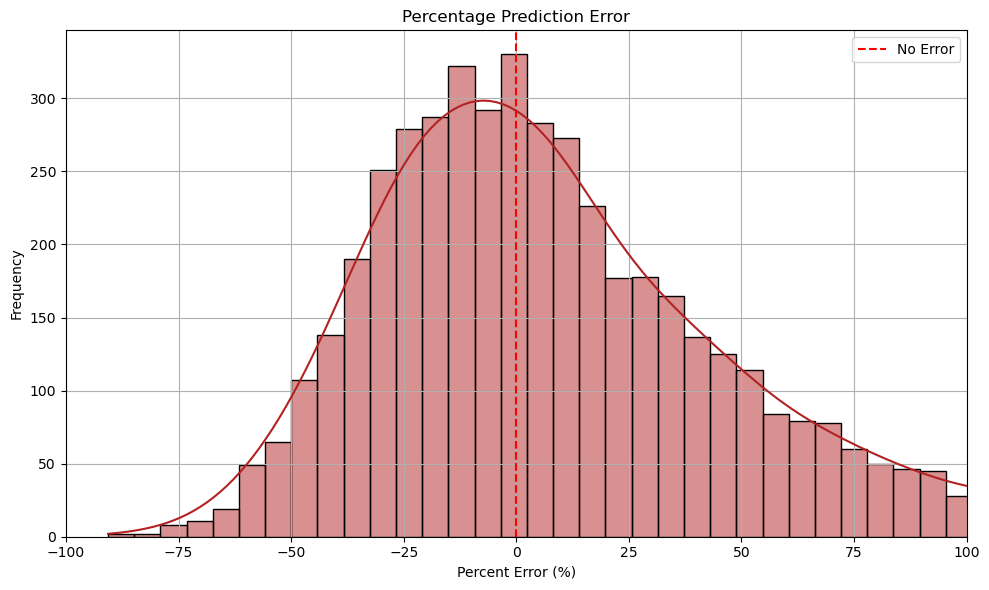

In [44]:
percent_error = ((y_pred - y_test) / y_test) * 100
percent_error_clipped = percent_error.clip(lower=-200, upper=200)

plt.figure(figsize=(10, 6))
plt.xlim(-100, 100)
sns.histplot(percent_error_clipped, bins=50, kde=True, color='firebrick')
plt.axvline(0, color='red', linestyle='--', label='No Error')
plt.title('Percentage Prediction Error')
plt.xlabel('Percent Error (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Final XGBoost

In [45]:

df = pd.read_csv("pricedata.csv")

numeric_features = ["Stories","Year_Built", "Rooms","FinishedSqft", "Units", "Bdrms", "Fbath", "Hbath","FIREPLACE", "AIR_CONDITIONING", "POWDER_ROOMS"]
categorical_features =["PropType", "Style", "Extwall"]
all_numeric= numeric_features + ['Sale_price']
for col in all_numeric: #convert all numeric values to a string (helps to remove commas and dollar signs)
    df[col] = df[col].astype(str)

for col in all_numeric: #remove commas from numeric values
    df[col] = df[col].str.replace(',', '', regex=False)

for col in all_numeric: #remove dollar signs from numeric values
    df[col] = df[col].str.replace(r'\$', '', regex=True)

for col in all_numeric: #convert back to numeric (coerce is just to handle nan)
    df[col] = pd.to_numeric(df[col],errors='coerce')

df.dropna(subset=['Sale_price'], inplace=True)

X = df.drop(columns=['Sale_price'])
y = df['Sale_price']

#For missing numerical features, the mean is taken
#Numerical features are normalized
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


#For missing Categorical Features, the mode is taken
#Categorical features are also onehotencoded
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
#Model is based on GridSearch Hyperparameter tuning
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
    n_estimators=700,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=0,

))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 401284662383.48785
R² Score: 0.3589863526273941


### XGBoost Over Random Splits

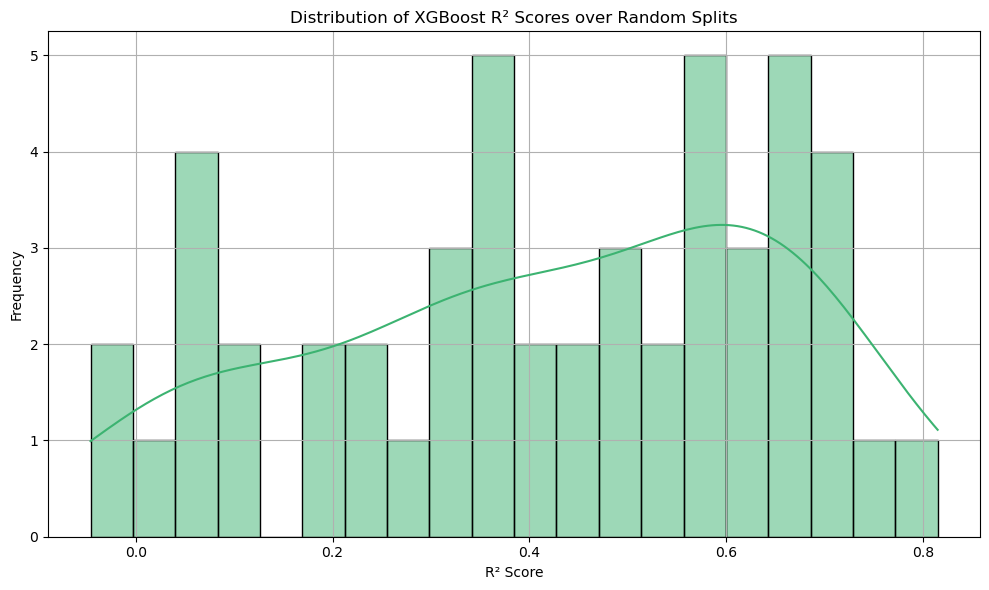

Mean R²: 0.4181, Std Dev: 0.2316


In [ ]:


scores = []
#Collecting the R2 scores across 50 runs, each with a different random_state
n = 50

for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    scores.append(r2)

plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=20, kde=True, color='mediumseagreen')
plt.title("Distribution of XGBoost R² Scores over Random Splits")
plt.xlabel("R² Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Mean R²: {np.mean(scores):.4f}, Std Dev: {np.std(scores):.4f}")

### XGBoost Over Random Splits (Outliers Removed)

In [47]:


df = pd.read_csv("pricedata.csv")
numeric_features = ["Stories","Year_Built", "Rooms","FinishedSqft", "Units", "Bdrms", "Fbath", "Hbath","FIREPLACE", "AIR_CONDITIONING", "POWDER_ROOMS"]
categorical_features =["PropType", "Style", "Extwall"]
all_numeric= numeric_features + ['Sale_price']

for col in all_numeric: #convert all numeric values to a string (helps to remove commas and dollar signs)
    df[col] = df[col].astype(str)

for col in all_numeric: #remove commas from numeric values
    df[col] = df[col].str.replace(',', '', regex=False)

for col in all_numeric: #remove dollar signs from numeric values
    df[col] = df[col].str.replace(r'\$', '', regex=True)

for col in all_numeric: #convert back to numeric (coerce is just to handle nan)
    df[col] = pd.to_numeric(df[col],errors='coerce')


df.dropna(subset=['Sale_price'], inplace=True)

#Removing extremes
low = df['Sale_price'].quantile(0.01)
high = df['Sale_price'].quantile(0.99)
df = df[(df['Sale_price'] >= low) & (df['Sale_price'] <= high)]

X = df.drop(columns=['Sale_price'])
y = df['Sale_price']



numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

xgb_regressor = XGBRegressor(
    n_estimators=700,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=0,

)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_regressor)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 6956829850.791971
R² Score: 0.6325306162702312


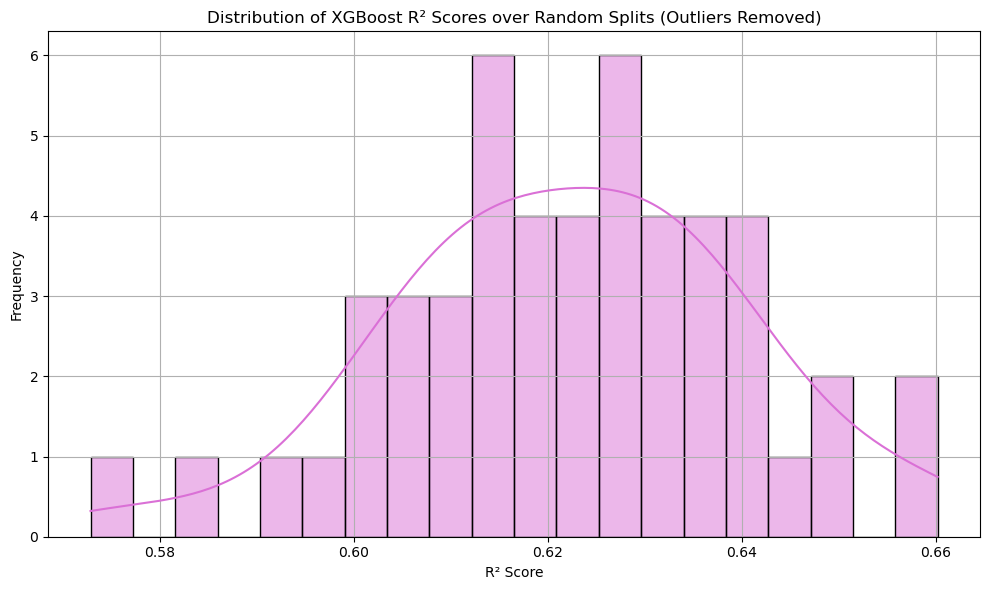

Mean R²: 0.6222, Std Dev: 0.0180


In [48]:


scores = []

n = 50

for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    scores.append(r2)

plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=20, kde=True, color='orchid')
plt.title("Distribution of XGBoost R² Scores over Random Splits (Outliers Removed)")
plt.xlabel("R² Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Mean R²: {np.mean(scores):.4f}, Std Dev: {np.std(scores):.4f}")